# Bayesian active learning with GPs in many dimensions

* This notebook provides simple code examples leveraging a light-weight GP implementation by [scikit-learn](https://scikit-learn.org/stable) to illustrate the workings of Bayesian active learning (BAL)in combination with regression in several dimensions. BAL is a technique from the reinforcement learning literature to automatically place observations in regions of the state space where they improve most on the quality of the approximator.

* It is supplementary material to the paper "Machine Learning for [Dynamic Incentive Problems" by P. Renner, S. Scheidegger (2018)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3282487), Section 4.3.

* BAL tackles this so-called exploration-exploitation dilemma—that is to say, the use of as few observations as possible to represent the a priori unknown polices as well as possible-by inducing observations to the training set such that only the relevant part of the state space will be explored. Hence, BAL can be seen as a strategy for optimal data selection to make learning more efficient. In our case, the training data is selected according to a function that we denote as score function. 

* In loose terms, Bayesian active learning could be considered to be the grid-free equivalent of an adaptive sparse grid algorithm. In the latter global solution method, the adaptivity of the grid now ensures that grid points are placed close to the nonlinearities while the grid remains coarse where policy functions are smoother.

* The notebook first introduces first all building blocks to BAL, and then runs the tests at the very end.

* We compare GPs trained on data that is uniformly distributed with GPs that were trained on data that was generated using BAL.

* There are several multi-d test functions below to play with. More can be found e.g. in [GENZ (1984)](https://www.sfu.ca/~ssurjano/integration.html).

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
import itertools

* First, we define a few multi-dimensional test functions.

* The test functions stem e.g. from [GENZ (1984)](https://www.sfu.ca/~ssurjano/integration.html).

In [2]:
# TEST function

def func(p):
    """ GAUSSIAN PEAK INTEGRAND FAMILY """
    a1 = 5.0
    u1 = 0.8
    a2 = 5.0
    u2 = 0.8
    return np.exp(- (a1**2*(p[:,0] - u1)**2.0 + a2**2*(p[:,1] - u2)**2.0))

def func1(p):
    """ RIDGE """
    d = p.shape[1]
    return np.maximum(0.0, 1.0 - np.exp(0.5 - np.prod(p + 0.2, axis=1) ** (1.0 / d)))

def func2(p):
    """ PRODUCT PEAK INTEGRAND FAMILY """
    return 1/(np.abs(0.5-p[:,0]**4+p[:,1]**5)+0.1)

def func3(p):
    """ Multi-d Sine Wave """
    return p[:,0]**np.sin(p[:,0])*p[:,1]**np.sin(p[:,1])

def func4(p):
    """ PRODUCT PEAK INTEGRAND FAMILY """
    a1 = 5.0
    u1 = 0.5
    a2 = 5.0
    u2 = 0.5
    pi1 = (1.0/a1**2) + ((p[:,0] - u1)**2.0)
    pi2 = (1.0/a2**2) + ((p[:,1] - u2)**2.0)
    pi = (1/pi1)*(1/pi2)
    return np.exp(- (a1**2*(p[:,0] - u1)**2.0 + a2**2*(p[:,1] - u2)**2.0))

In [3]:
def compute_moments(x, gp):
    """Calculate posterior predictive mean and variance of x* conditional on the training set."""

    e_gp, K = gp.predict(x, return_cov=True)
    k_xnew = K[-1, -1]
    k_xnew_xtrain = K[-1, :-1]
    K_xtrain = K[:-1, :-1]
    var_gp = k_xnew - np.dot(np.dot(k_xnew_xtrain, np.linalg.inv(K_xtrain)), k_xnew_xtrain.T)

    return e_gp[-1], var_gp

In [4]:
def bal_utility(e_gp, var_gp, rho=0.5, beta=0.5):
    """Calculate utility for Bayesian active learning."""
    utility = rho * e_gp + (beta / 2.0) * np.log(var_gp)

    return utility

In [5]:
def run_classical_gpr(x_test, d=1, n_min=10, new_point_per_step=2, number_of_steps=10):
    np.random.seed(12345)
    y_test = func(x_test)

    err_list = {}
    x_list = {}
    y_list = {}
    for k in range(number_of_steps):
        if k == 0:
            x_train = np.random.uniform(size=(n_min, d))
            y_train = func(x_train)
            x_list[k] = x_train
            y_list[k] = y_train
        else:
            x_new = np.random.uniform(size=(new_point_per_step, d))
            y_new = func(x_new)
            x_train = np.concatenate([x_train, x_new], axis=0)
            y_train = np.concatenate([y_train, y_new], axis=0)
            x_list[k] = x_new
            y_list[k] = y_new

        #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        # kernel = RBF(10, (1e-2, 1e2))
        kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0), nu=1.5)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
        gp.fit(x_train, y_train)
        y_pred = gp.predict(x_test)
        err = np.mean(np.abs((y_pred - y_test)))
        err = np.abs(y_pred - y_test)
        err_list[x_train.shape[0]] = err
    return pd.DataFrame(err_list), x_list, y_list

In [6]:
def run_bal(x_test, d=1, n_min=10, new_point_per_step=2, number_of_steps=10,nb_candidates=1000):
    np.random.seed(12345)
    y_test = func(x_test)
    err_list = {}
    x_list = {}
    y_list = {}
    for k in range(number_of_steps):
        if k == 0:
            # we are in the first round and generate random points
            x_train = np.random.uniform(size=(n_min, d))
            y_train = func(x_train)
            x_list[k] = x_train
            y_list[k] = y_train
        else:
            # generate a grid of candidates points
            x_candidates = np.random.uniform(size=(nb_candidates, d))
            U_bal = np.zeros_like(x_candidates)
            for i, _x in enumerate(x_candidates):
                x_tmp = np.concatenate([x_train, np.atleast_2d(_x)])
                try:
                    e_gp, var_gp = compute_moments(x_tmp, gp)
                    U_bal[i] = bal_utility(e_gp, var_gp)
                except:
                    # if the linalg svd can't be run, we put - infinity utility
                    U_bal[i] = -1e999

            U_bal = np.nan_to_num(U_bal, nan=-1e999)
            i_new = np.argsort(U_bal[:, 0])[-new_point_per_step:]
            print('At BAL step ', k ,' Adding', len(i_new), 'points to BAL')
            x_new = x_candidates[i_new, :]
            y_new = func(x_new)
            x_train = np.concatenate([x_train, x_new], axis=0)
            y_train = np.concatenate([y_train, y_new], axis=0)

            x_list[k] = x_new
            y_list[k] = y_new


        # kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        # kernel = RBF(10, (1e-2, 1e2))
        kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0), nu=1.5)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
        gp.fit(x_train, y_train)
        y_pred = gp.predict(x_test)
        err = np.mean(np.abs((y_pred - y_test)))
        err = np.abs(y_pred - y_test)
        err_list[x_train.shape[0]] = err
    return pd.DataFrame(err_list), x_list,y_list

In [7]:
def do_3d_scatter(x_list, y_list):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    cmap = plt.get_cmap('Reds')
    list_id = np.linspace(0.25, 1, len(x_list))
    for k in x_list.keys():
        label = None
        if k==min(x_list.keys()):
            label = 'First round'
        if k == max(x_list.keys()):
            label = 'Last round'
        ax.scatter(x_list[k][:,0], x_list[k][:,1], y_list[k], color = cmap(list_id[k-1]), label=label)
    plt.legend()

* After all functions are defined, we approximate the test functions with ordinary GPs, and GPs combined to BAL.

* We compare GPs that were trained on a training set of size N, and compare it to a training set of the same size, where the data is strategically generated via BAL.


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


At BAL step  1  Adding 1 points to BAL
At BAL step  2  Adding 1 points to BAL
At BAL step  3  Adding 1 points to BAL
At BAL step  4  Adding 1 points to BAL
At BAL step  5  Adding 1 points to BAL
At BAL step  6  Adding 1 points to BAL
At BAL step  7  Adding 1 points to BAL
At BAL step  8  Adding 1 points to BAL
At BAL step  9  Adding 1 points to BAL
At BAL step  10  Adding 1 points to BAL
At BAL step  11  Adding 1 points to BAL
At BAL step  12  Adding 1 points to BAL
At BAL step  13  Adding 1 points to BAL
At BAL step  14  Adding 1 points to BAL
At BAL step  15  Adding 1 points to BAL


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


At BAL step  16  Adding 1 points to BAL
At BAL step  17  Adding 1 points to BAL
At BAL step  18  Adding 1 points to BAL
At BAL step  19  Adding 1 points to BAL
At BAL step  20  Adding 1 points to BAL
At BAL step  21  Adding 1 points to BAL
At BAL step  22  Adding 1 points to BAL
At BAL step  23  Adding 1 points to BAL
At BAL step  24  Adding 1 points to BAL
At BAL step  25  Adding 1 points to BAL
At BAL step  26  Adding 1 points to BAL
At BAL step  27  Adding 1 points to BAL
At BAL step  28  Adding 1 points to BAL
At BAL step  29  Adding 1 points to BAL
At BAL step  30  Adding 1 points to BAL
At BAL step  31  Adding 1 points to BAL
At BAL step  32  Adding 1 points to BAL
At BAL step  33  Adding 1 points to BAL
At BAL step  34  Adding 1 points to BAL
At BAL step  35  Adding 1 points to BAL
At BAL step  36  Adding 1 points to BAL
At BAL step  37  Adding 1 points to BAL
At BAL step  38  Adding 1 points to BAL
At BAL step  39  Adding 1 points to BAL


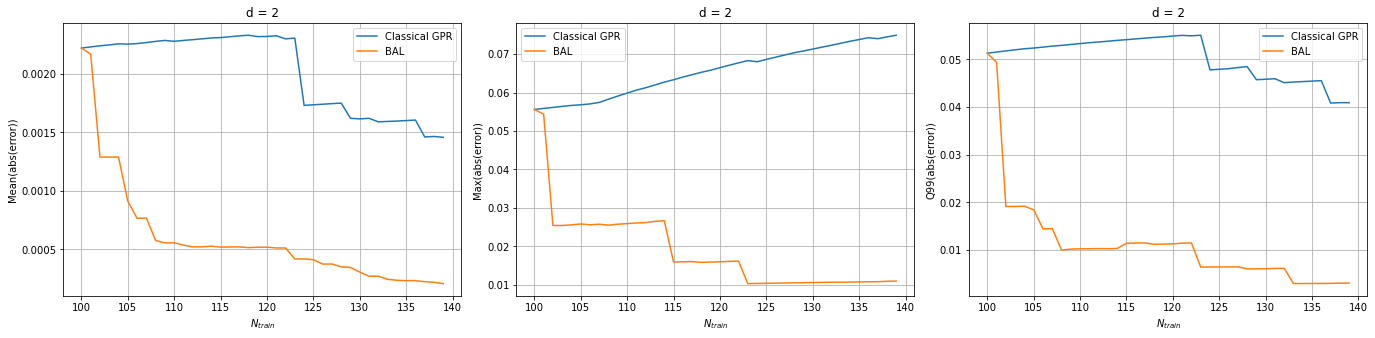

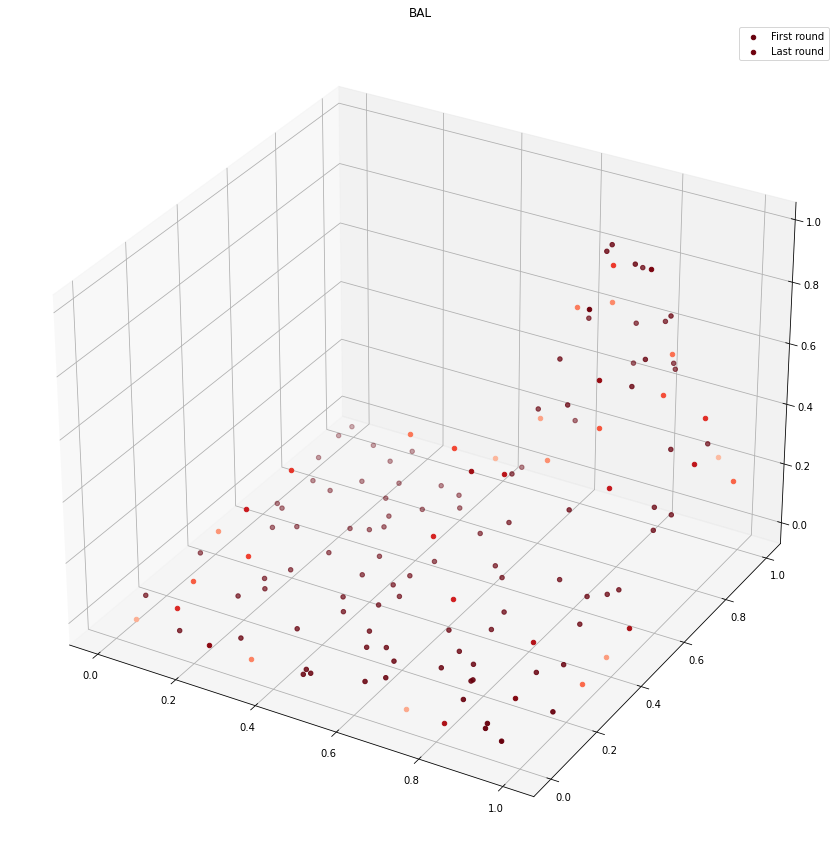

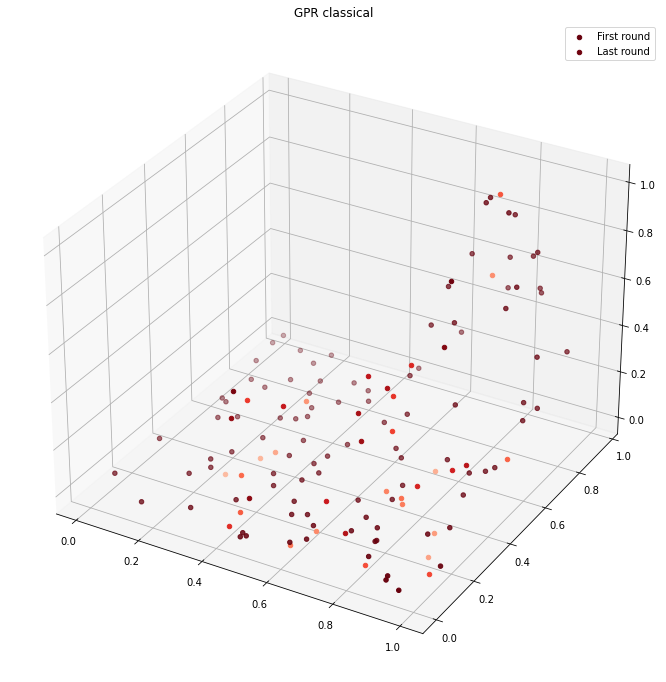

0 [0.92961609 0.18391881 0.56772503 0.96451452 0.74890664 0.74771481
 0.0083883  0.29870371 0.80981255 0.9646476  0.64247533 0.46759901
 0.43964461 0.99401459 0.79082252 0.02684928 0.90372254 0.49174732
 0.59636601 0.89508953 0.81835001 0.81018941 0.21895004 0.46810575
 0.70950978 0.53144988 0.76881392 0.60949366 0.4896267  0.84860141
 0.38384872 0.56839415 0.12584154 0.79960672 0.97322998 0.88842172
 0.35161653 0.50392912 0.24497444 0.49517241 0.94537183 0.25249259
 0.36743876 0.22657505 0.65085179 0.76873545 0.85240948 0.10732291
 0.33605516 0.89810064 0.195795   0.62699988 0.14294502 0.68934133
 0.64736168 0.71111596 0.90015968 0.02052082 0.65222542 0.68235638
 0.92649017 0.07215988 0.61524318 0.41536335 0.09739317 0.46466286
 0.69427746 0.72981142 0.01509884 0.78937872 0.31278596 0.36449029
 0.17730381 0.29009467 0.45399488 0.88263445 0.27927336 0.19862361
 0.85441357 0.05225335 0.48049627 0.37362046 0.60390723 0.8388657
 0.40070104 0.89312431 0.98919701 0.73147716 0.88328949 0.955

In [8]:
if __name__ == "__main__":
    np.random.seed(12345)
    d = 2                   # dimension of problem
    n_min = 100               # size of uniform sample befor BAL starts
    new_point_per_chunk = 1 # number of points that are added to the training set by using BAL
    number_of_steps = 40    # number of rounds BAL is applied
    nb_candidates = 1000    # total number of candidate points used in BAL
    
    x_test = np.random.uniform(size=(10000, d))
    
    # Train GPs on training sets of varing size - data generated by uniformly sampling
    classical_res, x_list_classic, y_list_classic = run_classical_gpr(x_test, d=d, n_min=n_min, new_point_per_step=new_point_per_chunk, number_of_steps=number_of_steps)

    # Train GPs on training sets of varing size - data generated by usnig BAL
    bal_res, x_list_bal, y_list_bal = run_bal(x_test, d=d, n_min=n_min, new_point_per_step=new_point_per_chunk, number_of_steps=number_of_steps,nb_candidates=nb_candidates)

    # generate a sequence of plots
    
    # L2-error
    plt.figure(figsize=(6.4*3,4.8))
    plt.subplot(1,3,1)
    classical_res.mean().plot()
    bal_res.mean().plot()
    plt.legend(['Classical GPR','BAL'])
    plt.grid()
    plt.title(f'd = {d}')
    plt.ylabel('Mean(abs(error))')
    plt.xlabel(r'$N_{train}$')
    plt.tight_layout()

    # Max error
    plt.subplot(1,3,2)
    classical_res.max().plot()
    bal_res.max().plot()
    plt.legend(['Classical GPR','BAL'])
    plt.grid()
    plt.title(f'd = {d}')
    plt.ylabel('Max(abs(error))')
    plt.xlabel(r'$N_{train}$')
    plt.tight_layout()

    # percentile error
    plt.subplot(1,3,3)
    q = 0.999
    classical_res.quantile(q).plot()
    bal_res.quantile(q).plot()
    plt.legend(['Classical GPR','BAL'])
    plt.grid()
    plt.title(f'd = {d}')
    plt.ylabel(f'Q{int(100*q)}(abs(error))')
    plt.xlabel(r'$N_{train}$')
    plt.tight_layout()
    plt.show()

    do_3d_scatter(x_list_bal,y_list_bal)
    plt.title('BAL')
    plt.tight_layout()
    plt.show()

    do_3d_scatter(x_list_classic,y_list_classic)
    plt.title('GPR classical')
    plt.show()


    # BAL data
    for k in x_list_bal.keys():
        print(k,x_list_bal[k][:,0], x_list_bal[k][:,1], y_list_bal[k])
        
    print("=================")
    # uniform data to file
    for k in x_list_classic.keys():
        print(k,x_list_classic[k][:,0], x_list_classic[k][:,1], y_list_classic[k])
        
    # print error from BAL
    #print(bal_res.mean())
    
    # print error from Classical 
    #print(classical_res.mean())